In [1]:
import cv2, os, numpy as np
import matplotlib.pyplot as plt

# ---------- Haar cascade ----------
def load_face_cascade():
    candidates = [
        "models/haarcascade_frontalface_default.xml",
        os.path.join(os.getcwd(), "haarcascade_frontalface_default.xml"),
        os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml"),
    ]
    for p in candidates:
        if os.path.exists(p):
            c = cv2.CascadeClassifier(p)
            if not c.empty():
                return c
    raise IOError("Haar cascade not found. Put 'haarcascade_frontalface_default.xml' in ./models/ or project root.")

_FACE_CASCADE = load_face_cascade()

def detect_largest_face_bgr(bgr_img, scaleFactor=1.1, minNeighbors=5):
    if bgr_img is None: return None, None
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    faces = _FACE_CASCADE.detectMultiScale(gray, scaleFactor, minNeighbors)
    if len(faces) == 0: return None, None
    (x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
    return (x, y, w, h), bgr_img[y:y+h, x:x+w]


In [2]:
# ==== Visualize full preprocessing pipeline with individual steps ====
import cv2, numpy as np, matplotlib.pyplot as plt

IMSIZE = 224  # CNN input size

img_path = r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data_raw\Akshay Kumar\Akshay Kumar_1.jpg"

bgr = cv2.imread(img_path)
if bgr is None:
    raise FileNotFoundError(f"Cannot read image: {img_path}")

# 1) Detect face
(box, crop) = detect_largest_face_bgr(bgr)
if crop is None:
    print("❌ No face detected!")
else:
    x, y, w, h = box
    bgr_box = bgr.copy()
    cv2.rectangle(bgr_box, (x,y), (x+w,y+h), (0,255,0), 3)

    # 2) Individual steps applied to the *crop* to isolate each effect
    step_auto   = auto_gamma(crop)               # auto-gamma only
    step_clahe  = clahe_bgr(crop)                # CLAHE only (on L channel in LAB)
    step_unsharp= unsharp(crop, amt=0.7, rad=1.5)# unsharp only

    # 3) Combined "soft_repair": auto-gamma -> CLAHE -> unsharp (your training pipeline)
    combo = unsharp(clahe_bgr(auto_gamma(crop)), amt=0.7, rad=1.5)

    # 4) Final resize + normalize (CNN input)
    final_bgr = cv2.resize(combo, (IMSIZE, IMSIZE), interpolation=cv2.INTER_AREA)
    final_rgb = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # ---- Plot all stages ----
    def show(ax, img_bgr_or_rgb, title, is_bgr=True):
        if is_bgr:
            ax.imshow(cv2.cvtColor(img_bgr_or_rgb, cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img_bgr_or_rgb)
        ax.set_title(title)
        ax.axis('off')

    plt.figure(figsize=(18,9))

    # Row 1
    ax = plt.subplot(2,4,1); show(ax, bgr_box, "Original + Detection", is_bgr=True)
    ax = plt.subplot(2,4,2); show(ax, crop,    "Cropped Face",        is_bgr=True)
    ax = plt.subplot(2,4,3); show(ax, step_auto,   "Auto-Gamma ONLY",  is_bgr=True)
    ax = plt.subplot(2,4,4); show(ax, step_clahe,  "CLAHE ONLY",       is_bgr=True)

    # Row 2
    ax = plt.subplot(2,4,5); show(ax, step_unsharp, "Unsharp ONLY",    is_bgr=True)
    ax = plt.subplot(2,4,6); show(ax, combo,        "Combined Repair\n(Gamma→CLAHE→Unsharp)", is_bgr=True)
    ax = plt.subplot(2,4,7); show(ax, final_bgr,    f"Resized {IMSIZE}×{IMSIZE}", is_bgr=True)
    ax = plt.subplot(2,4,8); show(ax, final_rgb,    "Final Normalized [0,1]",   is_bgr=False)

    plt.suptitle("Preprocessing Pipeline — Individual Effects and Final Input", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()


NameError: name 'auto_gamma' is not defined

In [ ]:
## testing purpose

In [ ]:
# === Cell 0: Imports & config ===
import os, cv2, math, shutil, random, glob, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms as T

from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support

# Paths (edit these)
RAW_DIR   = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data_raw")     # your folder-per-person raw images
PROC_DIR  = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data\data_proc")    # will be created: train/val/test subfolders
CASCADE   = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"

# Splits
SPLIT = dict(train=0.70, val=0.15, test=0.15)
assert abs(sum(SPLIT.values()) - 1.0) < 1e-6

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


In [ ]:
# === Cell 1: Haar detect, quality checks & repair, crop ===
# Load Haar cascade
_FACE = cv2.CascadeClassifier(CASCADE)
if _FACE.empty():
    raise IOError("Haar cascade not found. Check CASCADE path.")

def detect_largest_face_bgr(bgr_img, scaleFactor=1.1, minNeighbors=5):
    if bgr_img is None: return None, None
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    faces = _FACE.detectMultiScale(gray, scaleFactor, minNeighbors)
    if len(faces) == 0: return None, None
    (x, y, w, h) = max(faces, key=lambda r: r[2]*r[3])
    return (x, y, w, h), bgr_img[y:y+h, x:x+w]

# Quality metrics
def lap_var(gray):  # blur score
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Repair helpers
def auto_gamma(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    m = gray.mean() + 1e-6
    gamma = np.clip(np.log(128.0)/np.log(m), 0.5, 2.0)
    lut = np.array([((i/255.0)**gamma)*255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, lut)

def clahe_bgr(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l,a,b = cv2.split(lab)
    l = cv2.createCLAHE(2.0,(8,8)).apply(l)
    return cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2BGR)

def unsharp(img, amt=0.7, rad=1.5):
    blur = cv2.GaussianBlur(img, (0,0), rad)
    return cv2.addWeighted(img, 1+amt, blur, -amt, 0)

def soft_repair(bgr):
    """Try to improve brightness/contrast and mild blur; return repaired image."""
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    m, s, v = gray.mean(), gray.std(), lap_var(gray)
    # brightness/contrast
    if (m < 60 or m > 190) or (s < 25):
        bgr = clahe_bgr(auto_gamma(bgr))
        gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY); m, s = gray.mean(), gray.std()
    # blur
    if v < 80:
        bgr = unsharp(bgr, amt=0.7, rad=1.5)
    return bgr

def crop_and_repair(bgr, min_face=80, out_size=112):
    """Detect largest face, soft-repair, resize to out_size."""
    box, face = detect_largest_face_bgr(bgr)
    if face is None: return None
    # attempt repair
    face = soft_repair(face)
    h,w = face.shape[:2]
    if min(h,w) < min_face:
        # upscale a bit if only slightly small
        scale = max(min_face/min(h,w), 1.0)
        if scale > 1.6:  # too small -> not useful
            return None
        face = cv2.resize(face, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_LANCZOS4)
    # final resize for CNN
    face = cv2.resize(face, (out_size, out_size), interpolation=cv2.INTER_AREA)
    return face


In [ ]:
# === Cell 2: Build processed dataset with splits ===
def make_clean_dir(path: Path):
    if path.exists(): shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def split_indices(n, train_p, val_p, test_p):
    idx = list(range(n))
    random.shuffle(idx)
    n_train = int(n*train_p)
    n_val   = int(n*val_p)
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]
    return train_idx, val_idx, test_idx

def build_processed_dataset(raw_dir=RAW_DIR, proc_dir=PROC_DIR, out_size=112):
    print("Building processed dataset...")
    make_clean_dir(proc_dir)
    for split in ["train","val","test"]:
        (proc_dir/split).mkdir(parents=True, exist_ok=True)

    persons = sorted([p for p in raw_dir.iterdir() if p.is_dir()])
    kept, skipped = 0, 0

    for person_dir in persons:
        images = []
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp","*.webp"):
            images += glob.glob(str(person_dir / ext))
        if len(images) < 2:
            print(f"Skipping '{person_dir.name}' (not enough images).")
            continue

        # crop/repair all first
        crops = []
        for path in images:
            bgr = cv2.imread(path)
            face = crop_and_repair(bgr, out_size=out_size)
            if face is not None:
                crops.append((path, face))
            else:
                skipped += 1

        if len(crops) < 2:
            print(f"Skipping '{person_dir.name}' (no usable faces).")
            continue

        # split indices on crops
        ti, vi, si = split_indices(len(crops), SPLIT["train"], SPLIT["val"], SPLIT["test"])
        for split, idxs in (("train",ti),("val",vi),("test",si)):
            outp = proc_dir / split / person_dir.name
            outp.mkdir(parents=True, exist_ok=True)
            for j,k in enumerate(idxs):
                _, img = crops[k]
                cv2.imwrite(str(outp / f"{j:05d}.jpg"), img)
                kept += 1

    print(f"Done. Kept: {kept} | Skipped: {skipped}")
    # quick sanity
    for split in ("train","val","test"):
        print(split, "classes:", len(list((proc_dir/split).glob("*"))))

# Run once (comment after built)
build_processed_dataset(out_size=112)


Building processed dataset...
Done. Kept: 2475 | Skipped: 87
train classes: 31
val classes: 31
test classes: 31


In [ ]:
import tensorflow as tf
from pathlib import Path

PROC_DIR = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data\data_proc")   # <-- your preprocessed dataset root
IMSIZE = 224
BATCH = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    PROC_DIR/"train", image_size=(IMSIZE, IMSIZE), batch_size=BATCH,
    label_mode="categorical", shuffle=True, seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    PROC_DIR/"val", image_size=(IMSIZE, IMSIZE), batch_size=BATCH,
    label_mode="categorical", shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    PROC_DIR/"test", image_size=(IMSIZE, IMSIZE), batch_size=BATCH,
    label_mode="categorical", shuffle=False
)

NUM_CLASSES = train_ds.element_spec[1].shape[-1]
print("Classes:", NUM_CLASSES)


Found 1718 files belonging to 31 classes.
Found 357 files belonging to 31 classes.
Found 400 files belonging to 31 classes.
Classes: 31


In [ ]:
from tensorflow.keras import layers as L

data_augment = tf.keras.Sequential([
    L.RandomFlip("horizontal"),
    L.RandomZoom(0.1),
    L.RandomContrast(0.1),
])

def prep_pipeline(ds, train=False):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y), num_parallel_calls=tf.data.AUTOTUNE)
    if train:
        ds = ds.map(lambda x,y: (data_augment(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(1000, seed=SEED)
    return ds.cache().prefetch(tf.data.AUTOTUNE)

train_tf = prep_pipeline(train_ds, train=True)
val_tf   = prep_pipeline(val_ds,   train=False)
test_tf  = prep_pipeline(test_ds,  train=False)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(IMSIZE,IMSIZE,3))
base.trainable = False  # freeze backbone first

inp = Input((IMSIZE,IMSIZE,3))
x = base(inp, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
emb = Dense(128, activation="relu", name="embedding")(x)
x = Dropout(0.3)(emb)
out = Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inp, out)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,425,951 (9.25 MB)

 Trainable params: 167,967 (656.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import os, tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

os.makedirs("../output/checkpoints_mnet", exist_ok=True)
os.makedirs("../output/artifacts_mnet", exist_ok=True)

# --- Callbacks (save full model in .keras format) ---
cbs = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(
        filepath="../output/checkpoints_mnet/best_mnetv2.keras",   # <- native Keras format
        monitor="val_loss",
        save_best_only=True,                        # keep only the best epoch
        save_weights_only=False                     # save full model+optimizer
    ),
]

# --- Warm-up (frozen backbone) ---
hist1 = model.fit(train_tf, validation_data=val_tf, epochs=8, callbacks=cbs)

# --- Safer fine-tune: unfreeze only the last ~25 layers; keep BatchNorm frozen ---
UNFREEZE_LAST = 25

for layer in base.layers:
    layer.trainable = False

for layer in base.layers[-UNFREEZE_LAST:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Fine-tune ---
hist2 = model.fit(train_tf, validation_data=val_tf, epochs=15, callbacks=cbs)

# --- Save the final state (last epoch) in .keras too ---
model.save("../output/artifacts/final_mnetv2.keras")   # includes architecture, weights, optimizer state

# (optional) Evaluate using the BEST checkpoint (usually better than last epoch)
best = tf.keras.models.load_model("checkpoints/best_mnetv2.keras")
test_loss, test_acc = best.evaluate(test_tf)
print("Test accuracy (best):", test_acc)


Epoch 1/8


54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.0984 - loss: 3.3544 - val_accuracy: 0.2185 - val_loss: 2.9295 - learning_rate: 0.0010
Epoch 2/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 408ms/step - accuracy: 0.2002 - loss: 2.7880 - val_accuracy: 0.3754 - val_loss: 2.4200 - learning_rate: 0.0010
Epoch 3/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 462ms/step - accuracy: 0.3248 - loss: 2.2990 - val_accuracy: 0.4594 - val_loss: 2.0124 - learning_rate: 0.0010
Epoch 4/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.3900 - loss: 2.0229 - val_accuracy: 0.5378 - val_loss: 1.7774 - learning_rate: 0.0010
Epoch 5/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step - accuracy: 0.4563 - loss: 1.7716 - val_accuracy: 0.5378 - val_loss: 1.6487 - learning_rate: 0.0010
Epoch 6/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.5064 - loss: 1.5513 - val_accuracy: 0.5462 - val_loss: 1.5401 - learning_rate: 0.0010
Epoch 7/8
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.5471 - loss: 1.4484 - val_accura

## Evaluation

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 314ms/step - accuracy: 0.7275 - loss: 0.9849 - top5_acc: 0.9375

[Keras evaluate()]
accuracy: 0.727500
loss: 0.984894
top5_acc: 0.937500

[Custom metrics]
Top-1 Acc  : 0.7275
Top-5 Acc  : 0.9375
Precision  : macro=0.7389 | micro=0.7275 | weighted=0.7429
Recall     : macro=0.7187 | micro=0.7275 | weighted=0.7275
F1-score   : macro=0.7193  | micro=0.7275  | weighted=0.7255
ROC-AUC(m) : 0.9801494615089976

[Per-class accuracy]
 - 0: 0.6250
 - 1: 1.0000
 - 2: 0.3333
 - 3: 0.8333
 - 4: 0.6667
 - 5: 0.6364
 - 6: 0.6429
 - 7: 0.7895
 - 8: 0.8462
 - 9: 0.6923
 - 10: 0.6667
 - 11: 0.5000
 - 12: 1.0000
 - 13: 0.5455
 - 14: 0.9167
 - 15: 0.8235
 - 16: 0.5333
 - 17: 0.7059
 - 18: 0.5294
 - 19: 0.2000
 - 20: 0.9091
 - 21: 0.5000
 - 22: 0.6000
 - 23: 0.7647
 - 24: 0.8125
 - 25: 0.7222
 - 26: 0.8182
 - 27: 1.0000
 - 28: 0.8824
 - 29: 1.0000
 - 30: 0.7857

[Classification report]
              precision    recall  f1-score   support

           0     0.6250    0.6250    0

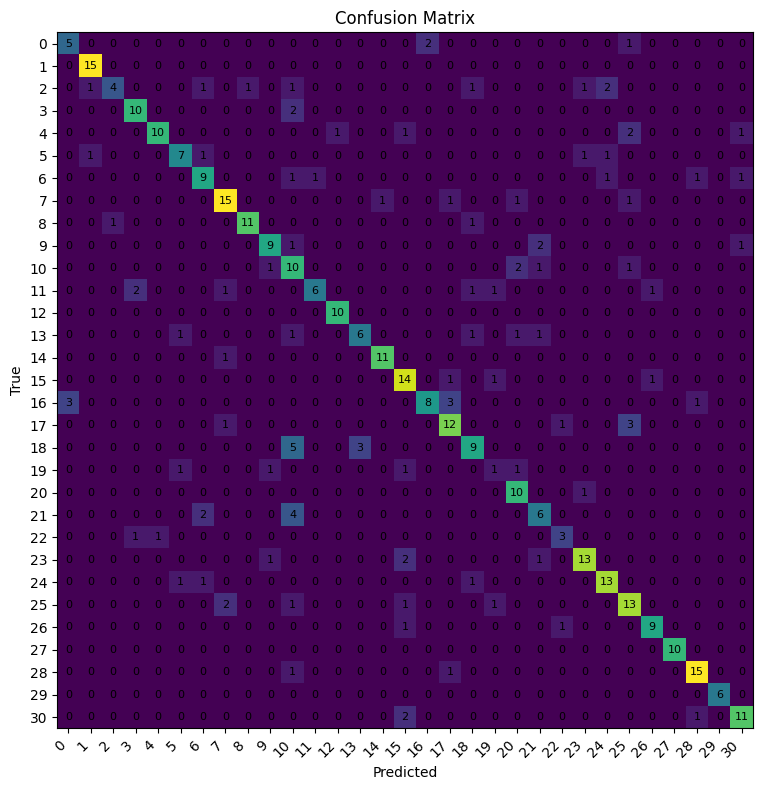


Saved to artifacts/test_metrics.json and artifacts/confusion_matrix.npy


In [ ]:
# === Cell: Full evaluation for MobileNetV2 face ID ===
import os, json, numpy as np, tensorflow as tf
from pathlib import Path

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt

# ---- paths ----
BEST_CKPT = "checkpoints/best_mnetv2.keras"   # from your callbacks
OUT_DIR   = "artifacts"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# (Optional) class names; leave as None to auto-generate 0..C-1
CLASS_NAMES = None

# ---- load best model and add extra eval metrics ----
best = tf.keras.models.load_model(BEST_CKPT)
# recompile only to get extra metrics for model.evaluate (won't change weights)
extra_metrics = [
    "accuracy",
    tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5_acc"),
]
best.compile(optimizer="adam", loss="categorical_crossentropy", metrics=extra_metrics)

# ---- quick Keras eval ----
eval_dict = best.evaluate(test_tf, return_dict=True, verbose=1)
print("\n[Keras evaluate()]")
for k, v in eval_dict.items():
    print(f"{k}: {v:.6f}")

# ---- collect predictions & labels (works for one-hot OR integer labels) ----
y_true_list, y_prob_list = [], []
for xb, yb in test_tf:
    prob = best.predict(xb, verbose=0)
    y_prob_list.append(prob)
    y_true_list.append(yb.numpy())

y_prob = np.concatenate(y_prob_list, axis=0)
y_true_arr = np.concatenate(y_true_list, axis=0)

num_classes = y_prob.shape[1]
if y_true_arr.ndim > 1:     # one-hot
    y_true_idx = y_true_arr.argmax(axis=1)
    y_true_1h  = y_true_arr
else:                       # integer labels
    y_true_idx = y_true_arr.astype(int)
    y_true_1h  = tf.keras.utils.to_categorical(y_true_idx, num_classes=num_classes)

y_pred_idx = y_prob.argmax(axis=1)

# ---- top-1 / top-5 accuracy ----
top1_acc = accuracy_score(y_true_idx, y_pred_idx)
top5_hits = np.any(
    np.argsort(y_prob, axis=1)[:, -5:] == y_true_idx[:, None],
    axis=1
).mean()

# ---- precision / recall / f1 (macro/micro/weighted) ----
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average="macro", zero_division=0
)
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average="micro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average="weighted", zero_division=0
)

# ---- confusion matrix & per-class accuracy ----
cm = confusion_matrix(y_true_idx, y_pred_idx, labels=list(range(num_classes)))
per_class_acc = {}
if CLASS_NAMES is None:
    CLASS_NAMES = [str(i) for i in range(num_classes)]
for i, name in enumerate(CLASS_NAMES):
    row_sum = cm[i].sum()
    per_class_acc[name] = float(cm[i, i] / row_sum) if row_sum > 0 else 0.0

# ---- ROC-AUC (macro, OvR) ----
try:
    roc_auc_macro = roc_auc_score(y_true_1h, y_prob, multi_class="ovr", average="macro")
except Exception:
    roc_auc_macro = None

# ---- print summary ----
print("\n[Custom metrics]")
print(f"Top-1 Acc  : {top1_acc:.4f}")
print(f"Top-5 Acc  : {top5_hits:.4f}")
print(f"Precision  : macro={prec_macro:.4f} | micro={prec_micro:.4f} | weighted={prec_weighted:.4f}")
print(f"Recall     : macro={rec_macro:.4f} | micro={rec_micro:.4f} | weighted={rec_weighted:.4f}")
print(f"F1-score   : macro={f1_macro:.4f}  | micro={f1_micro:.4f}  | weighted={f1_weighted:.4f}")
print(f"ROC-AUC(m) : {roc_auc_macro if roc_auc_macro is not None else 'N/A'}")

print("\n[Per-class accuracy]")
for cls, acc in per_class_acc.items():
    print(f" - {cls}: {acc:.4f}")

print("\n[Classification report]")
print(classification_report(y_true_idx, y_pred_idx, target_names=CLASS_NAMES, digits=4, zero_division=0))

# ---- plot confusion matrix ----
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm)  # no explicit colors/style per your environment rules
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha="right"); ax.set_yticklabels(CLASS_NAMES)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()

# ---- save artifacts ----
report = {
    "keras_evaluate": {k: float(v) for k, v in eval_dict.items()},
    "top1_acc": float(top1_acc),
    "top5_acc": float(top5_hits),
    "precision": {"macro": float(prec_macro), "micro": float(rec_micro), "weighted": float(prec_weighted)},
    "recall":    {"macro": float(rec_macro), "micro": float(rec_micro), "weighted": float(rec_weighted)},
    "f1":        {"macro": float(f1_macro),  "micro": float(f1_micro),  "weighted": float(f1_weighted)},
    "roc_auc_macro_ovr": (None if roc_auc_macro is None else float(roc_auc_macro)),
    "per_class_accuracy": per_class_acc,
    "class_names": CLASS_NAMES,
}
with open(os.path.join(OUT_DIR, "test_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(report, f, indent=2)
np.save(os.path.join(OUT_DIR, "confusion_matrix.npy"), cm)
print(f"\nSaved to {OUT_DIR}/test_metrics.json and {OUT_DIR}/confusion_matrix.npy")


In [ ]:
test_loss, test_acc = model.evaluate(test_tf)
print(f"TEST  loss={test_loss:.4f}  acc={test_acc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.7275 - loss: 0.9849
TEST  loss=0.9849  acc=0.7275


                    precision    recall  f1-score   support

      Akshay Kumar       0.62      1.00      0.76         8
Alexandra Daddario       1.00      1.00      1.00        15
        Alia Bhatt       0.77      0.83      0.80        12
  Amitabh Bachchan       1.00      0.83      0.91        12
      Andy Samberg       0.86      0.80      0.83        15
    Anushka Sharma       0.88      0.64      0.74        11
     Billie Eilish       0.73      0.57      0.64        14
         Brad Pitt       0.82      0.74      0.78        19
    Camila Cabello       1.00      0.92      0.96        13
   Charlize Theron       0.65      0.85      0.73        13
       Claire Holt       0.50      0.73      0.59        15
      Courtney Cox       0.80      0.67      0.73        12
    Dwayne Johnson       0.82      0.90      0.86        10
   Elizabeth Olsen       0.67      0.91      0.77        11
   Ellen Degeneres       0.85      0.92      0.88        12
      Henry Cavill       0.79      0.88

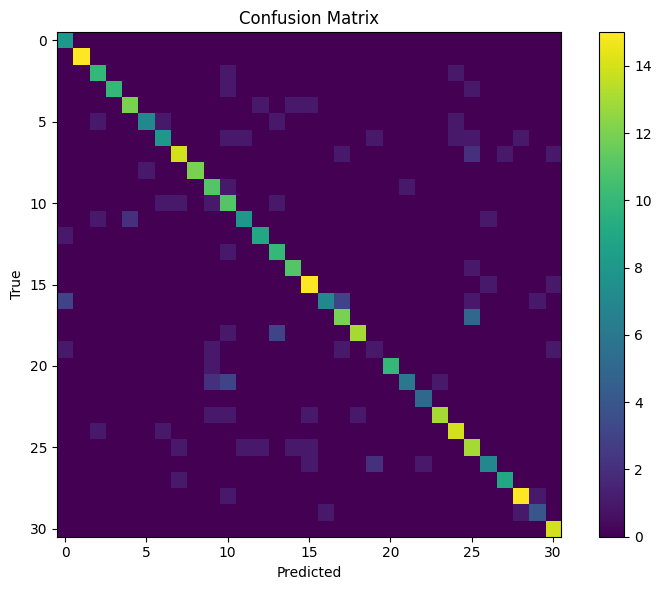

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# collect predictions & true labels
y_true, y_pred = [], []
for xb, yb in test_tf:
    p = model.predict(xb, verbose=0)
    y_pred.append(np.argmax(p, axis=1))
    y_true.append(np.argmax(yb.numpy(), axis=1))
y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)

# per-class names from disk (same as you just saved)
from pathlib import Path
PROC_DIR = Path(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\data\data_proc")
CLASS_NAMES = sorted([p.name for p in (PROC_DIR/"train").iterdir() if p.is_dir()])

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# confusion matrix heatmap (optional)
cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASS_NAMES)))
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model

# load your trained model
model = tf.keras.models.load_model(r"C:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\face_mnetv2_finetuned.keras")

# build an embedding model from it
embed_model = Model(model.input, model.get_layer("embedding").output)

# cosine helper
import numpy as np
def cosine(a,b):
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-9))


c:\Users\jians\Documents\GitHub\SMART-Barcode-Scanner-and-Face-Recognition\.venv\lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import numpy as np
from sklearn.metrics import roc_curve

def cosine(a,b):
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-9))

# 1. Collect embeddings for val set
def collect_embeds(ds):
    embs, ys = [], []
    for xb, yb in ds:
        e = embed_model.predict(xb, verbose=0)
        embs.append(e)
        ys.append(yb.numpy())
    return np.vstack(embs), np.argmax(np.vstack(ys), axis=1)

emb_val, y_val = collect_embeds(val_ds)

# 2. Build pairs (genuine vs impostor)
pos, neg = [], []
rng = np.random.default_rng(42)
idx = np.arange(len(y_val))
for c in np.unique(y_val):
    ids = np.where(y_val==c)[0]
    if len(ids) > 1:
        for i in range(len(ids)-1):
            pos.append(cosine(emb_val[ids[i]], emb_val[ids[i+1]]))
while len(neg) < len(pos):
    i, j = rng.choice(idx, 2, replace=False)
    if y_val[i] != y_val[j]:
        neg.append(cosine(emb_val[i], emb_val[j]))

y_true = np.array([1]*len(pos) + [0]*len(neg))
y_score = np.array(pos + neg)

# 3. Compute ROC and EER threshold
fpr, tpr, thr = roc_curve(y_true, y_score)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer_thr = thr[eer_idx]
print(f"✅ EER threshold ≈ {eer_thr:.3f}")


✅ EER threshold ≈ 0.918


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image as KImage

def predict_image(path, size=224, topk=3):
    img = KImage.load_img(path, target_size=(size,size))
    x = KImage.img_to_array(img)[None] / 255.0
    p = model.predict(x, verbose=0)[0]
    idx = np.argsort(-p)[:topk]
    return [(CLASS_NAMES[i], float(p[i])) for i in idx]

import cv2

# Assumes you already defined crop_and_repair(bgr, out_size=...)
# (from your earlier cells). If not, paste that function here.

def embed_path_raw(path, size=224):
    bgr = cv2.imread(path)
    if bgr is None:
        raise FileNotFoundError(path)
    face = crop_and_repair(bgr, out_size=size)   # 🔑 same preprocessing as training set
    if face is None:                              # fallback if no face found
        face = cv2.resize(bgr, (size, size))
    rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    x = np.expand_dims(rgb, 0)
    e = embed_model.predict(x, verbose=0)[0]
    return e / (np.linalg.norm(e) + 1e-9)


def verify_paths(p1, p2, thr):
    e1, e2 = embed_path_raw(p1), embed_path_raw(p2)
    sim = cosine(e1, e2)
    print(f"cosine={sim:.3f}  thr={thr:.3f}  ->  {'MATCH ✅' if sim>=thr else 'NOT MATCH ❌'}")



In [ ]:
# ===== Full embedder + camera capture (Keras 3 safe) =====
import os, cv2, numpy as np, tensorflow as tf
from tensorflow import keras

# ----------------- Config: set your paths here -----------------
EMBEDDER_PATH   = None                               # e.g. "checkpoints/best_embedder.keras"
CLASSIFIER_PATH = "checkpoints/best_mnetv2.keras"    # your classifier .keras
INPUT_SIZE      = 224                                # must match your training
# ---------------------------------------------------------------

# ---------- Face cascade loader ----------
def get_face_cascade():
    candidates = [
        "models/haarcascade_frontalface_default.xml",
        os.path.join(os.getcwd(), "haarcascade_frontalface_default.xml"),
        os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml"),
    ]
    for p in candidates:
        if os.path.exists(p):
            cc = cv2.CascadeClassifier(p)
            if not cc.empty():
                return cc
    raise IOError("Haar cascade not found. Put 'haarcascade_frontalface_default.xml' in ./models/ or project root.")

# ---------- Build embedder from classifier (.keras) ----------
def build_embedder_from_classifier(classifier_model):
    """
    Picks a good feature tensor (prefers a GAP layer), then adds L2 normalization
    via a proper Keras layer (UnitNormalization or Lambda).
    Returns a frozen keras.Model that outputs unit-length embeddings.
    """
    net = classifier_model

    # 1) choose a feature tensor
    #    prefer a named "embedding" layer; else the last GlobalPool; else penultimate layer
    feat = None
    try:
        feat = net.get_layer("embedding").output
    except Exception:
        pass

    if feat is None:
        for L in reversed(net.layers):
            if isinstance(L, (keras.layers.GlobalAveragePooling2D, keras.layers.GlobalMaxPooling2D)):
                feat = L.output
                break

    if feat is None:
        # last resort: penultimate layer
        feat = net.layers[-2].output

    # 2) add L2 norm as a Keras layer (Keras 3 safe)
    try:
        emb_out = keras.layers.UnitNormalization(axis=-1, name="l2norm_out_eval")(feat)
    except Exception:
        emb_out = keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1),
                                      name="l2norm_out_eval")(feat)

    embedder = keras.Model(net.input, emb_out, name="embedder_eval")
    embedder.trainable = False
    return embedder

# ---------- Load model (embedder preferred; else derive from classifier) ----------
def load_embedder():
    if EMBEDDER_PATH and os.path.exists(EMBEDDER_PATH):
        print(f"[INFO] Loading embedder: {EMBEDDER_PATH}")
        m = keras.models.load_model(EMBEDDER_PATH, compile=False)
        m.trainable = False
        return m
    if not os.path.exists(CLASSIFIER_PATH):
        raise FileNotFoundError(f"Neither EMBEDDER_PATH nor CLASSIFIER_PATH found.\n"
                                f"Checked: {EMBEDDER_PATH} and {CLASSIFIER_PATH}")
    print(f"[INFO] Loading classifier: {CLASSIFIER_PATH} → deriving embedder")
    clf = keras.models.load_model(CLASSIFIER_PATH, compile=False)
    return build_embedder_from_classifier(clf)

# ---------- Preprocess (square pad + resize to INPUT_SIZE) ----------
def crop_and_repair(face_bgr, out_size=INPUT_SIZE):
    """
    Given a face crop (BGR), letterbox to a square and resize to (out_size, out_size).
    Matches typical training that used fixed input size. Adjust if you used other normalization.
    """
    if face_bgr is None:
        return None
    h, w = face_bgr.shape[:2]
    if h == 0 or w == 0:
        return None

    # keep aspect ratio by scaling the longer side to out_size and padding the other
    scale = out_size / max(h, w)
    new_w, new_h = int(round(w * scale)), int(round(h * scale))
    resized = cv2.resize(face_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # pad to square
    top = (out_size - new_h) // 2
    bottom = out_size - new_h - top
    left = (out_size - new_w) // 2
    right = out_size - new_w - left

    # reflect padding keeps borders natural; you can change to BORDER_CONSTANT if preferred
    squared = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                 borderType=cv2.BORDER_REFLECT_101)
    return squared

# ---------- Camera capture → embedding ----------
def capture_and_embed(thr=0.5, detector=None, embed_model=None):
    """
    Opens webcam, draws face boxes, SPACE to capture largest face,
    returns a unit-normalized embedding (np.ndarray) or None.
    """
    if embed_model is None:
        raise RuntimeError("embed_model is None. Call load_embedder() first and pass it in.")
    det = detector if detector is not None else _FACE

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("❌ Could not open camera.")
        return None

    print("Press SPACE to capture, ESC to quit.")
    emb_out = None

    while True:
        ok, frame = cap.read()
        if not ok:
            print("❌ Failed to read camera.")
            break

        frame = cv2.flip(frame, 1)  # mirror
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = det.detectMultiScale(gray, 1.1, 4)

        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.imshow("Camera", frame)

        key = cv2.waitKey(1) & 0xFF
        if key == 27:   # ESC
            print("Exit.")
            break
        if key == 32:   # SPACE
            if len(faces) == 0:
                print("❌ No face detected, try again.")
                continue
            x,y,w,h = max(faces, key=lambda r:r[2]*r[3])
            face = frame[y:y+h, x:x+w]

            face_proc = crop_and_repair(face, out_size=INPUT_SIZE)
            if face_proc is None:
                print("❌ Crop failed.")
                continue

            # match training preprocessing — adjust if you used other normalization
            rgb = cv2.cvtColor(face_proc, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
            x_in = np.expand_dims(rgb, 0)

            # embed (already L2-normalized by the model head we built)
            emb = embed_model.predict(x_in, verbose=0)[0]
            # If your saved embedder didn't include L2, keep this line; otherwise it’s harmless:
            emb = emb / (np.linalg.norm(emb) + 1e-9)

            print("✅ Captured embedding shape:", emb.shape, "| L2 norm ~", float(np.sum(emb**2)))
            emb_out = emb
            break  # remove this break if you want to keep capturing multiple

    cap.release()
    cv2.destroyAllWindows()
    return emb_out

# ----------------- Bootstrapping -----------------
# 1) face detector (global _FACE for compatibility with your earlier code)
_FACE = get_face_cascade()
print("Face cascade ready:", not _FACE.empty())

# 2) embedder
embed_model = load_embedder()
print("Embedder ready. Output dim:", embed_model.output_shape[-1])

# 3) run capture (returns a vector or None)
# emb = capture_and_embed(embed_model=embed_model)   # uncomment to run interactively
# print("Embedding vector (first 5):", None if emb is None else emb[:5])


Face cascade ready: True
[INFO] Loading classifier: checkpoints/best_mnetv2.keras → deriving embedder
Embedder ready. Output dim: 128


In [ ]:
# === Pairwise Verification: cosine + threshold ===
import os, numpy as np

def cosine(u, v):
    """Cosine similarity between two (optionally unnormalized) vectors."""
    u = u / (np.linalg.norm(u) + 1e-9)
    v = v / (np.linalg.norm(v) + 1e-9)
    return float(np.dot(u, v))

def cosine_verdict(e_enroll, e_probe, tau=0.90):
    """
    Decide match using cosine similarity and a threshold tau.
    Returns (score, decision_bool).
    """
    s = cosine(e_enroll, e_probe)
    ok = s >= tau
    print(f"[VERIFY] cosine={s:.4f} | tau={tau:.2f} → {'MATCH ✅' if ok else 'NOT MATCH ❌'}")
    return s, ok

# ---- Convenience: enroll/save/load/verify helpers ----
def enroll_and_save(name="user1", out_dir="enrollments", embed_model=None, detector=None):
    """
    Capture a single enrollment embedding and save to enrollments/<name>.npy
    """
    os.makedirs(out_dir, exist_ok=True)
    emb = capture_and_embed(embed_model=embed_model, detector=detector)  # thr arg kept in signature but unused
    if emb is None:
        print("❌ Enrollment failed.")
        return None, None
    path = os.path.join(out_dir, f"{name}.npy")
    np.save(path, emb.astype(np.float32))
    print(f"✔️ Saved enrollment to {path}")
    return emb, path

def average_enrollment(name="user1", k=3, out_dir="enrollments", embed_model=None, detector=None):
    """
    Take k enrollment captures, average them (then L2-normalize) for a more stable template.
    """
    os.makedirs(out_dir, exist_ok=True)
    vecs = []
    for i in range(k):
        print(f"[Enroll {i+1}/{k}]")
        e = capture_and_embed(embed_model=embed_model, detector=detector)
        if e is not None: vecs.append(e)
    if not vecs:
        print("❌ No valid captures.")
        return None, None
    v = np.mean(np.stack(vecs, axis=0), axis=0)
    v = v / (np.linalg.norm(v) + 1e-9)
    path = os.path.join(out_dir, f"{name}.npy")
    np.save(path, v.astype(np.float32))
    print(f"✔️ Saved averaged enrollment to {path}")
    return v, path

def verify_against_file(path, tau=0.90, embed_model=None, detector=None):
    """
    Load an enrolled template from disk, capture a live probe, and verify.
    """
    ref = np.load(path)
    probe = capture_and_embed(embed_model=embed_model, detector=detector)
    if probe is None:
        print("❌ Probe capture failed.")
        return None, None
    return cosine_verdict(ref, probe, tau=tau)

# ---- Quick usage patterns ----
# 1) In-memory pair:
e1 = capture_and_embed(thr=0.9, embed_model=embed_model, detector=_FACE)  # enrollment (thr kept for compatibility)
e2 = capture_and_embed(embed_model=embed_model, detector=_FACE)           # probe
s, ok = cosine_verdict(e1, e2, tau=0.90)

# 2) Persistent template:
# _, path = enroll_and_save("alice", embed_model=embed_model, detector=_FACE)
# s, ok = verify_against_file(path, tau=0.90, embed_model=embed_model, detector=_FACE)

# 3) Higher-quality template (averaged):
# _, path = average_enrollment("alice", k=5, embed_model=embed_model, detector=_FACE)
# s, ok = verify_against_file(path, tau=0.85, embed_model=embed_model, detector=_FACE)  # often can lower tau a bit


Press SPACE to capture, ESC to quit.
✅ Captured embedding shape: (128,) | L2 norm ~ 1.0000001192092896
Press SPACE to capture, ESC to quit.
✅ Captured embedding shape: (128,) | L2 norm ~ 1.0
[VERIFY] cosine=0.5559 | tau=0.90 → NOT MATCH ❌
